In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc


In [25]:
# Load the data from CSV file
df = pd.read_csv("bankruptcy.csv")
# df.head()

# Check for NaN Values
nan_rows = df[df.isna().any(axis=1)]
if len(nan_rows) > 0:
    print(nan_rows)
else:
    print("No NaN values found.")

No NaN values found.


### We will split the data into two different groups. The first dataframe will contain all 95 variables while the second dataframe will contain the top 10 variables with the highest correlation to bankruptcy. 

The cell below is for all variables

In [4]:
# Split the data into training and testing sets for all variables
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

y.value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [5]:
# Separate majority and minority classes
df_majority = df[df["Bankrupt?"] == 0]
df_minority = df[df["Bankrupt?"] == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42)  # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled["Bankrupt?"].value_counts()
X_upsample = df_upsampled.drop("Bankrupt?", axis=1)
y_upsample = df_upsampled["Bankrupt?"]

X_train_upsample, X_test_upsample, y_train_upsample, y_test_upsample = train_test_split(X_upsample, y_upsample, test_size=0.2,random_state=42)
y_upsample.value_counts()



0    6599
1    6599
Name: Bankrupt?, dtype: int64

The cell below is for the top 10 variables

In [7]:
# Split the data into training and testing sets for top 10 variables based on correlation with bankruptcy

corr_matrix = df_upsampled.corr()
num_features = 10
corr_with_bankrupt = corr_matrix["Bankrupt?"].abs().sort_values(ascending=False)
top_corr_features = corr_with_bankrupt[1:num_features+1].index.tolist()
df_top10_upsampled = df_upsampled[top_corr_features]
X_top10_upsample = df_top10_upsampled
y_top10_upsample = df_upsampled["Bankrupt?"]
X_train_top10_upsample, X_test_top10_upsample, y_train_top10_upsample, y_test_top10_upsample = train_test_split(X_top10_upsample, y_top10_upsample, test_size=0.2,random_state=42)

### Building a Neural Network Model

This code creates a neural network model using the Keras library with two layers. The first layer is a fully connected (Dense) layer with 64 neurons, which takes an input of shape X_train.shape[1] (the number of features in the training data) and uses the ReLU activation function. The second layer is another Dense layer with a single neuron and uses the sigmoid activation function, which is commonly used for binary classification problems.

In summary, the model has an input layer with the same number of neurons as the number of features in the data, one hidden layer with 64 neurons, and an output layer with a single neuron that outputs a probability between 0 and 1 representing the likelihood of the input belonging to the positive class (bankruptcy in this case).

In [8]:
# # Build the neural network model
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Differnt model (testing optimization)

# model2 = Sequential()
# model2.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# model2.add(BatchNormalization())
# model2.add(Dense(64, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(32, activation='relu'))
# model2.add(Dense(1, activation='sigmoid'))



# model_top10 = Sequential()
# model_top10.add(Dense(64, input_dim=X_train_top10.shape[1], activation='relu'))
# model_top10.add(Dense(32, activation='relu'))
# model_top10.add(Dense(32, activation='relu'))
# model_top10.add(Dense(32, activation='relu'))
# model_top10.add(Dense(32, activation='relu'))
# model_top10.add(Dense(1, activation='sigmoid'))

# model for upsampled data (All)

model_upsample_all = Sequential()
model_upsample_all.add(Dense(128, input_dim=X_train_upsample.shape[1], activation='relu'))
model_upsample_all.add(BatchNormalization())
model_upsample_all.add(Dense(64, activation='relu'))
model_upsample_all.add(Dropout(0.2))
model_upsample_all.add(Dense(32, activation='relu'))
model_upsample_all.add(Dense(1, activation='sigmoid'))


# model for upsampled data (Top 10)

model_upsample_top10 = Sequential()
model_upsample_top10.add(Dense(128, input_dim=X_train_top10_upsample.shape[1], activation='relu'))
model_upsample_top10.add(BatchNormalization())
model_upsample_top10.add(Dense(64, activation='relu'))
model_upsample_top10.add(Dropout(0.2))
model_upsample_top10.add(Dense(32, activation='relu'))
model_upsample_top10.add(Dense(1, activation='sigmoid'))

model.compile is a function in Keras that compiles the model with the chosen loss function, optimizer, and metrics. In this case, the loss function chosen is binary_crossentropy, which is commonly used for binary classification problems. The optimizer chosen is adam, which is a commonly used optimization algorithm for neural networks. Finally, metrics is set to accuracy, which will be used to evaluate the performance of the model during training and testing.

In [9]:
# # Compile the model for all variables
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Compile the model for top 10 variables
# model_top10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# compile the model for all variables with upsampled dataset

model_upsample_all.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# compile the model for top 10 variables with upsampled dataset

model_upsample_top10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#### This line of code trains the neural network model on the training data with the following parameters:

X_train and y_train: the input features and corresponding target variable used for training the model.
epochs=50: the number of times the model is trained on the entire training dataset.
batch_size=32: the number of samples that will be used in each batch of training.
validation_data=(X_test, y_test): the validation data on which the model will be evaluated after each epoch of training. The validation data is used to monitor the performance of the model on data that it has not seen during training.
During training, the model tries to minimize the binary cross-entropy loss function using the Adam optimizer. The accuracy metric is also computed during training to evaluate the performance of the model on the training data.

In [10]:
# # Train the model for all variables
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# # Train the model for top 10 variables

# model_top10.fit(X_train_top10, y_train_top10, epochs=50, batch_size=32, validation_data=(X_test_top10, y_test_top10))

# Train the model for all the variables with the upsampled dataset

model_upsample_all.fit(X_train_upsample, y_train_upsample, epochs=50, batch_size=32, validation_data=(X_test_upsample, y_test_upsample))

# Train the model for top 10 variables with the upsampled dataset


model_upsample_top10.fit(X_train_top10_upsample, y_train_top10_upsample, epochs=50, batch_size=32, validation_data=(X_test_top10_upsample, y_test_top10_upsample))



Epoch 1/50
330/330 [==============================] - 2s 3ms/step - loss: 0.5743 - accuracy: 0.6972 - val_loss: 0.4797 - val_accuracy: 0.7606
Epoch 2/50
330/330 [==============================] - 1s 2ms/step - loss: 0.4748 - accuracy: 0.7748 - val_loss: 0.4160 - val_accuracy: 0.8136
Epoch 3/50
330/330 [==============================] - 1s 2ms/step - loss: 0.4311 - accuracy: 0.7988 - val_loss: 0.3822 - val_accuracy: 0.8360
Epoch 4/50
330/330 [==============================] - 1s 2ms/step - loss: 0.4066 - accuracy: 0.8206 - val_loss: 0.3498 - val_accuracy: 0.8458
Epoch 5/50
330/330 [==============================] - 1s 2ms/step - loss: 0.3865 - accuracy: 0.8287 - val_loss: 0.3180 - val_accuracy: 0.8682
Epoch 6/50
330/330 [==============================] - 1s 2ms/step - loss: 0.3654 - accuracy: 0.8419 - val_loss: 0.3220 - val_accuracy: 0.8773
Epoch 7/50
330/330 [==============================] - 1s 2ms/step - loss: 0.3472 - accuracy: 0.8534 - val_loss: 0.2865 - val_accuracy: 0.8955
Epoch 

### Seeing the accuracy of our NN model(s)

In [12]:
# # Evaluate the model on the test data
# loss, accuracy = model.evaluate(X_test, y_test)

# # Print the accuracy
# print("Accuracy for dataset with all variables:", accuracy)

# loss2, accuracy2 = model2.evaluate(X_test, y_test)

# print("Accuracy for dataset with all variables using optimized NN:", accuracy2)


# loss_top10, accuracy_top10 = model_top10.evaluate(X_test_top10, y_test_top10)

# print("Accuracy for dataset with top 10 variables:", accuracy_top10)

#Accuracy for upsampled dataset for all the variables and optimised model
loss_upsample_all, accuracy_upsample_all = model_upsample_all.evaluate(X_test_upsample, y_test_upsample)

print("Accuracy for upsampled dataset with all variables:", accuracy_upsample_all)


#Accuracy for upsampled dataset for top 10 variables and optimised model
loss_upsample_top10, accuracy_upsample_top10 = model_upsample_top10.evaluate(X_test_top10_upsample, y_test_top10_upsample)

print("Accuracy for upsampled dataset with top 10 variables:", accuracy_upsample_top10)

83/83 [==============================] - 0s 1ms/step - loss: 0.1497 - accuracy: 0.9413
Accuracy for upsampled dataset with all variables: 0.9412878751754761
83/83 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.7515
Accuracy for upsampled dataset with top 10 variables: 0.7515151500701904


### Trying to do some visualisation of the data here


In [ ]:
# Create a correlation matrix
corr_matrix = df.corr()

# Generate a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')

# Show the plot
plt.show()

In [ ]:
#print(df.columns.to_list)

bankrupt_df = df[['Bankrupt?', ' Cash Flow to Sales']]
bankrupt_corr_matrix = bankrupt_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(bankrupt_corr_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation with Bankrupt?')
plt.show()




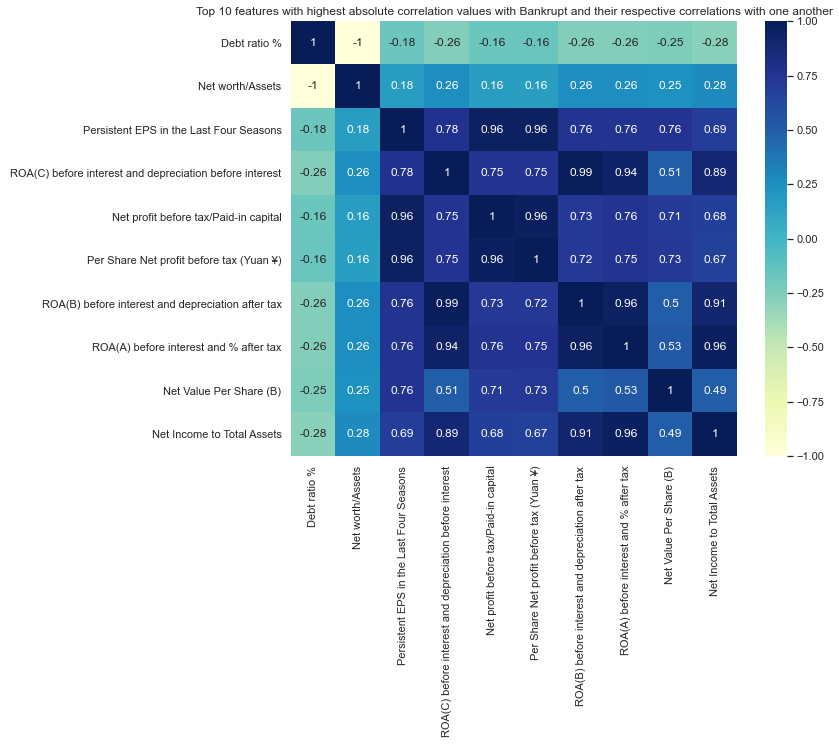

In [24]:
# Find the top 10 features with highest absolute correlation values with Bankrupt? column
num_features = 10
corr_with_bankrupt = corr_matrix["Bankrupt?"].abs().sort_values(ascending=False)
top_corr_features = corr_with_bankrupt[1:num_features+1].index.tolist()

# Create a heatmap of top 10 features with highest absolute correlation values
sns.set(style="white")
plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="YlGnBu")
plt.title("Top 10 features with highest absolute correlation values with Bankrupt and their respective correlations with one another", fontsize=12)
plt.show()

In [ ]:
# for feature in top_corr_features:
#     sns.violinplot(data=df[feature], orient = "h")
#     plt.title(feature)
#     plt.show()

In [ ]:
# for feature in top_corr_features:
#     sns.boxplot(data = df[feature], orient = "h")
#     plt.title(feature)
#     q1, q3 = df[feature].quantile([0.25, 0.75])
#     iqr = q3 - q1

#     # Identify the lower and upper bounds
#     lower_bound = q1 - (1.5 * iqr)
#     upper_bound = q3 + (1.5 * iqr)

#     # Count the number of outliers
#     outliers = len(df[(df[feature] < lower_bound) | (df[feature] > upper_bound)])

#     print(f"Number of Outliers for{feature}:", outliers)

#     plt.show()

In [ ]:
# Create scatter plot for each combination of top features
# for i in range(len(top_corr_features)):
#     for j in range(i+1, len(top_corr_features)):
#         feature1 = top_corr_features[i]
#         feature2 = top_corr_features[j]
#         sns.jointplot(x=feature1, y=feature2, data=df, kind='reg')
#         plt.show()

### Building a Decision Tree Model

This code trains a decision tree classifier model dectree with a maximum depth of 2 on the training data X_train and y_train.

After training, the model is visualized as a tree using the plot_tree function from sklearn.tree. The plot_tree function generates a tree diagram that shows the decision-making process of the decision tree model.

The filled=True argument fills the tree nodes with colors to indicate the class distribution, while the rounded=True argument makes the edges of the boxes around the nodes rounded.

The feature_names argument specifies the names of the input features or predictors, which are columns in the DataFrame X.

The class_names argument specifies the names of the target classes or outputs, which in this case are "Not Bankrupt" and "Bankrupt".

The resulting tree diagram can be used to interpret how the model makes predictions for new data based on the values of the input features.

[Text(0.5, 0.8333333333333334, ' Continuous interest rate (after tax) <= 0.782\ngini = 0.5\nsamples = 10558\nvalue = [5271, 5287]\nclass = Bankrupt'),
 Text(0.25, 0.5, ' Total debt/Total net worth <= 0.01\ngini = 0.334\nsamples = 5717\nvalue = [1212, 4505]\nclass = Bankrupt'),
 Text(0.125, 0.16666666666666666, 'gini = 0.499\nsamples = 1616\nvalue = [852, 764]\nclass = Not Bankrupt'),
 Text(0.375, 0.16666666666666666, 'gini = 0.16\nsamples = 4101\nvalue = [360, 3741]\nclass = Bankrupt'),
 Text(0.75, 0.5, ' Interest Expense Ratio <= 0.632\ngini = 0.271\nsamples = 4841\nvalue = [4059, 782]\nclass = Not Bankrupt'),
 Text(0.625, 0.16666666666666666, 'gini = 0.06\nsamples = 3536\nvalue = [3427, 109]\nclass = Not Bankrupt'),
 Text(0.875, 0.16666666666666666, 'gini = 0.5\nsamples = 1305\nvalue = [632, 673]\nclass = Bankrupt')]

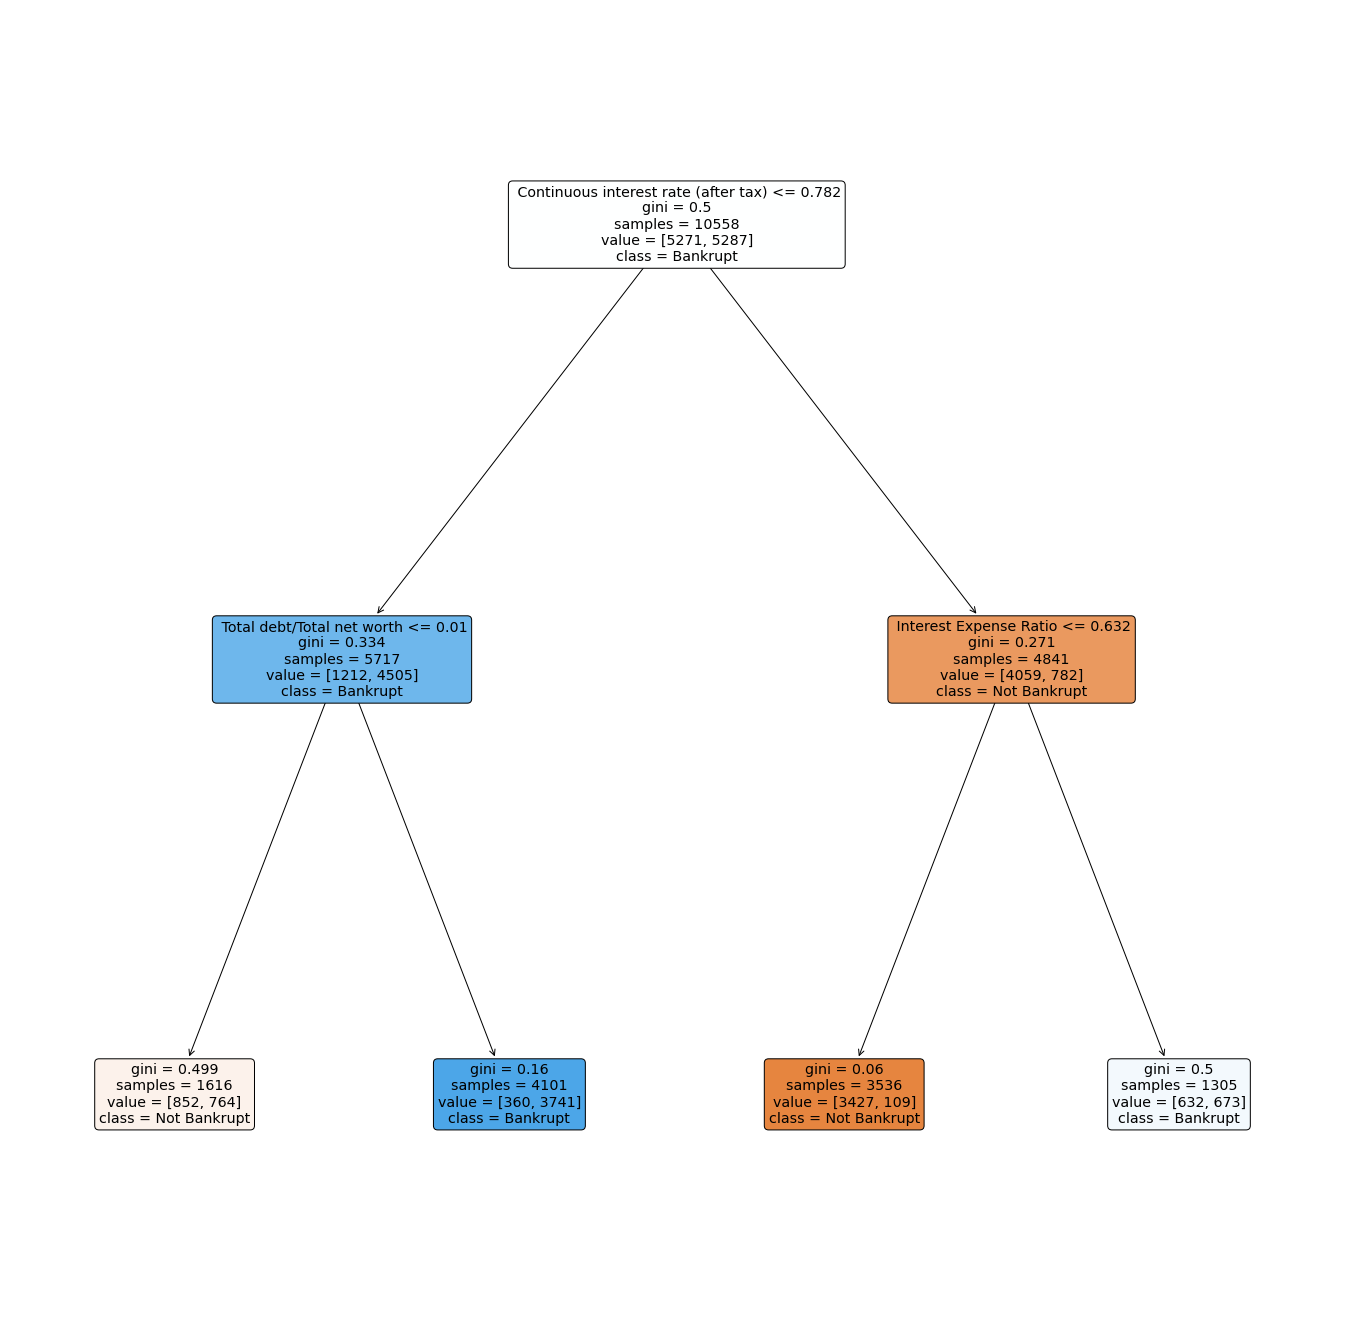

In [13]:
dectree_upsample = DecisionTreeClassifier(max_depth=2)
dectree_upsample.fit(X_train_upsample, y_train_upsample)

f = plt.figure(figsize=(24,24))
plot_tree(dectree_upsample, filled=True, rounded=True, 
          feature_names=X_upsample.columns, 
          class_names=["Not Bankrupt","Bankrupt"])

[Text(0.5, 0.8333333333333334, ' Persistent EPS in the Last Four Seasons <= 0.213\ngini = 0.5\nsamples = 10558\nvalue = [5271, 5287]\nclass = Bankrupt'),
 Text(0.25, 0.5, ' Debt ratio % <= 0.147\ngini = 0.31\nsamples = 5327\nvalue = [1020, 4307]\nclass = Bankrupt'),
 Text(0.125, 0.16666666666666666, 'gini = 0.5\nsamples = 1311\nvalue = [670, 641]\nclass = Not Bankrupt'),
 Text(0.375, 0.16666666666666666, 'gini = 0.159\nsamples = 4016\nvalue = [350, 3666]\nclass = Bankrupt'),
 Text(0.75, 0.5, ' Net worth/Assets <= 0.827\ngini = 0.304\nsamples = 5231\nvalue = [4251, 980]\nclass = Not Bankrupt'),
 Text(0.625, 0.16666666666666666, 'gini = 0.492\nsamples = 1008\nvalue = [440, 568]\nclass = Bankrupt'),
 Text(0.875, 0.16666666666666666, 'gini = 0.176\nsamples = 4223\nvalue = [3811, 412]\nclass = Not Bankrupt')]

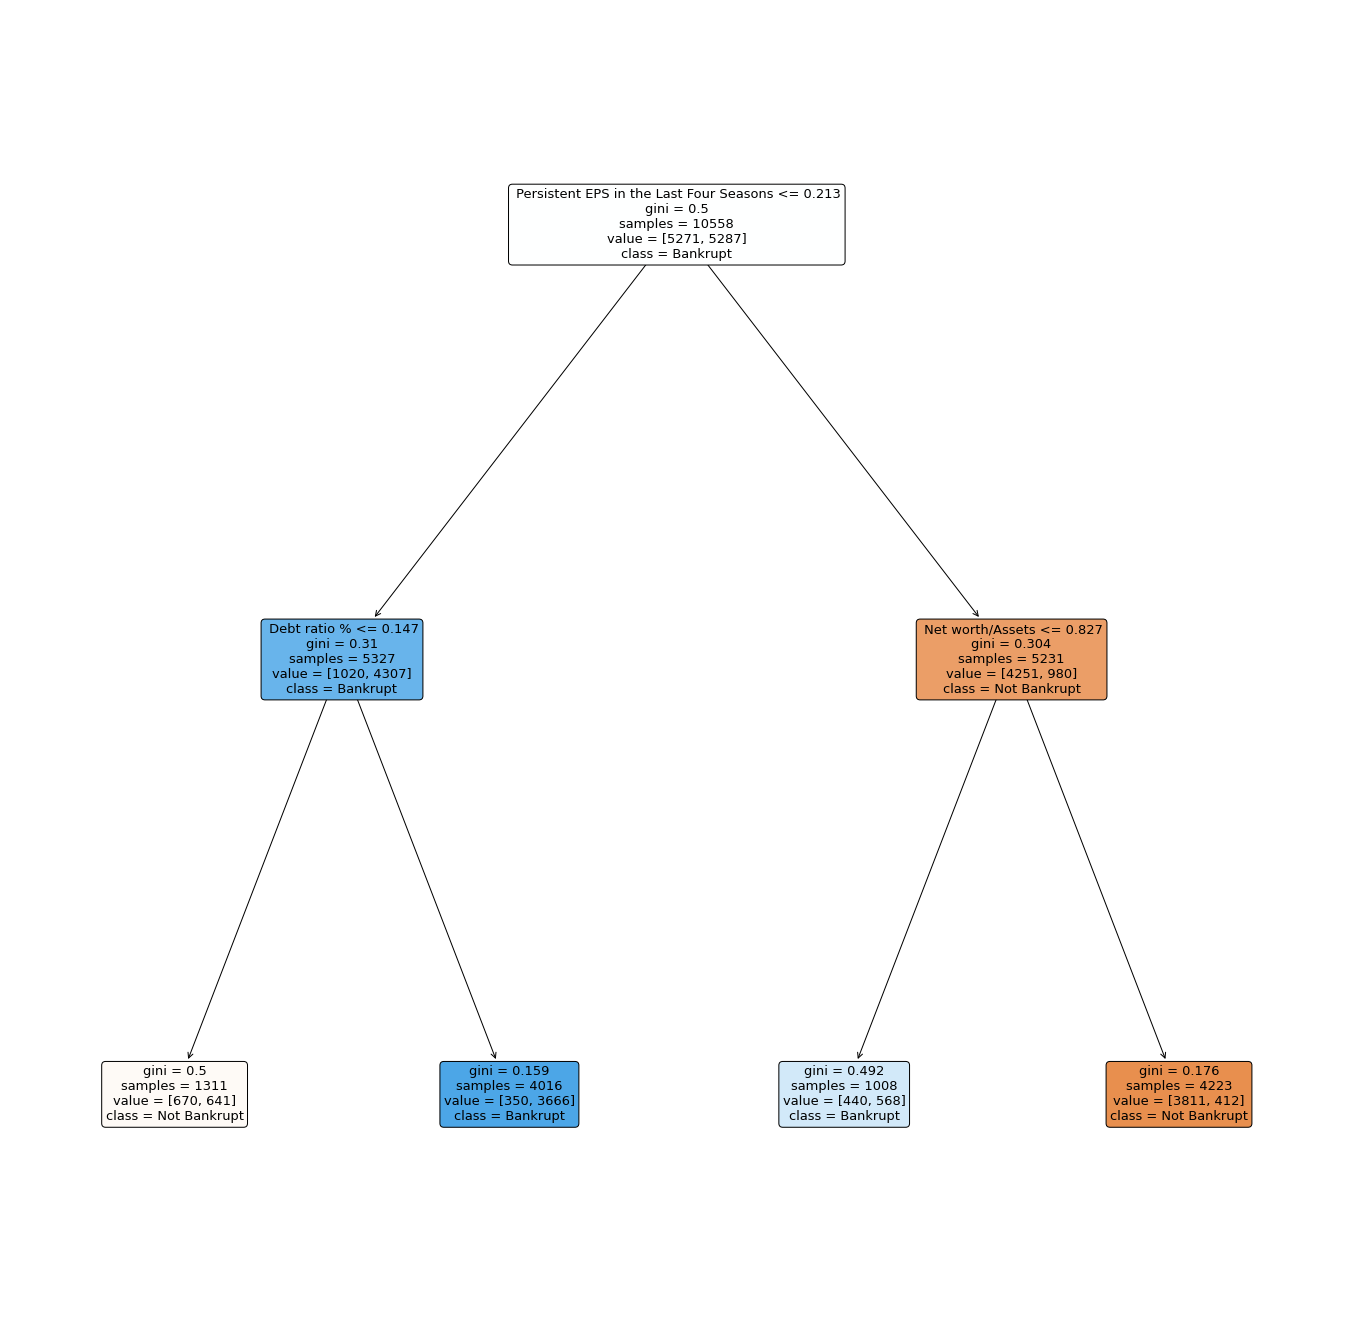

In [14]:
dectree_upsample_top10 = DecisionTreeClassifier(max_depth=2)
dectree_upsample_top10.fit(X_train_top10_upsample, y_train_top10_upsample)

f = plt.figure(figsize=(24,24))
plot_tree(dectree_upsample_top10, filled=True, rounded=True, 
          feature_names=X_top10_upsample.columns, 
          class_names=["Not Bankrupt","Bankrupt"])

### Seeing the accuracy of our Decision Tree Model

In [15]:
# Evaluate the accuracy of the model for all upsampled variables
y_pred_upsample = dectree_upsample.predict(X_test_upsample)

accuracy = accuracy_score(y_test_upsample, y_pred_upsample)
print("Accuracy of the model with all varaibles: {:.2f}%".format(accuracy*100))


# Evaluate the accuracy of the model for top 10 upsampled variables
y_pred_upsample_top10 = dectree_upsample_top10.predict(X_test_top10_upsample)

accuracy = accuracy_score(y_test_top10_upsample, y_pred_upsample_top10)
print("Accuracy of the model with top 10 variables: {:.2f}%".format(accuracy*100))


# # Evaluate the accuracy of the model for top 10 variables
# y_pred_top10 = dectree_top10.predict(X_test_top10)

# accuracy_top10 = accuracy_score(y_test_top10, y_pred_top10)
# print("Accuracy of the model: {:.2f}%".format(accuracy_top10*100))


Accuracy of the model with all varaibles: 82.61%
Accuracy of the model with top 10 variables: 82.80%


Let's run a for loop and see how the accuracy changes with the depth of the decision tree for both dataframes (all 95 variables and top 10 variables respectively)

In [17]:
# For top 95 upsampled
for i in range(1,50):
    dectree = DecisionTreeClassifier(max_depth=i)
    dectree.fit(X_train_upsample, y_train_upsample)
    y_pred_upsample = dectree.predict(X_test_upsample)
    accuracy = accuracy_score(y_test_upsample, y_pred_upsample)
    print(f"Accuracy of the model for all variables for tree of depth {i}: {accuracy*100:.2f}%")
print("----------")


# For top 10 upsampled
for i in range(1,50):
    dectree = DecisionTreeClassifier(max_depth=i)
    dectree.fit(X_train_top10_upsample, y_train_top10_upsample)
    y_pred_upsample_top10 = dectree.predict(X_test_top10_upsample)
    accuracy_top10 = accuracy_score(y_test_top10_upsample, y_pred_upsample_top10)
    print(f"Accuracy of the model for top 10 variables for tree of depth {i}: {accuracy_top10*100:.2f}%")
print("----------")
# # For top 10
# for i in range(1,50):
#     dectree_top10 = DecisionTreeClassifier(max_depth=i)
#     dectree_top10.fit(X_train_top10, y_train_top10)
#     y_pred_top10 = dectree_top10.predict(X_test_top10)
#     accuracy_top10 = accuracy_score(y_test_top10, y_pred_top10)
#     print(f"Accuracy of the model for top 10 variables tree of depth {i}: {accuracy_top10*100:.2f}%")


Accuracy of the model for all variables for tree of depth 1: 80.80%
Accuracy of the model for all variables for tree of depth 2: 82.61%
Accuracy of the model for all variables for tree of depth 3: 89.24%
Accuracy of the model for all variables for tree of depth 4: 92.39%
Accuracy of the model for all variables for tree of depth 5: 94.43%
Accuracy of the model for all variables for tree of depth 6: 95.80%
Accuracy of the model for all variables for tree of depth 7: 96.10%
Accuracy of the model for all variables for tree of depth 8: 96.52%
Accuracy of the model for all variables for tree of depth 9: 96.82%
Accuracy of the model for all variables for tree of depth 10: 96.89%
Accuracy of the model for all variables for tree of depth 11: 97.01%
Accuracy of the model for all variables for tree of depth 12: 97.23%
Accuracy of the model for all variables for tree of depth 13: 97.39%
Accuracy of the model for all variables for tree of depth 14: 97.61%
Accuracy of the model for all variables for

## This code block below plots the AUC for the NN model.

## JX us this code block to plot AUC for your model on the upsampled dataset

83/83 [==============================] - 0s 1ms/step


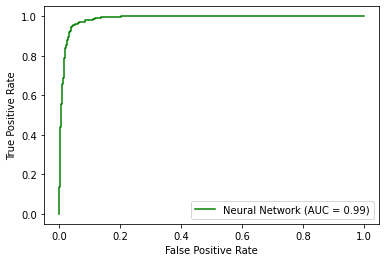

In [18]:


# predict probabilities with neural network model for all variables
nn_probs = model_upsample_all.predict(X_test_upsample)
# compare the predicted probabilities
fpr_nn, tpr_nn, _ = roc_curve(y_test_upsample, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, color='green', label='Neural Network (AUC = %0.2f)' % roc_auc_nn)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


83/83 [==============================] - 0s 1000us/step


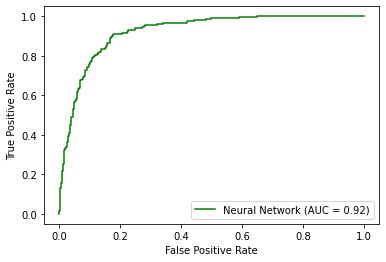

In [19]:
# predict probabilities with neural network model for top 10 variables
nn_probs_top10 = model_upsample_top10.predict(X_test_top10_upsample)
# compare the predicted probabilities
fpr_nn, tpr_nn, _ = roc_curve(y_test_top10_upsample, nn_probs_top10)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, color='green', label='Neural Network (AUC = %0.2f)' % roc_auc_nn)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


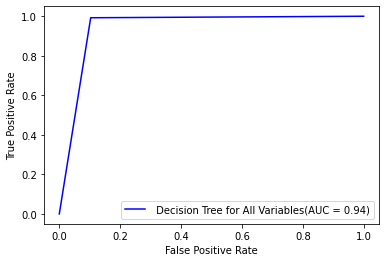

In [20]:

# create decision tree model and fit to training data for all variables

dt_model = DecisionTreeClassifier(max_depth=5)
dt_model.fit(X_train_upsample, y_train_upsample)
# predict probabilities with decision tree model
dt_probs = dt_model.predict(X_test_upsample)

fpr_dt, tpr_dt, _ = roc_curve(y_test_upsample, dt_probs)

roc_auc_dt = auc(fpr_dt, tpr_dt)


plt.plot(fpr_dt, tpr_dt, color='blue', label=' Decision Tree for All Variables(AUC = %0.2f)' % roc_auc_dt)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


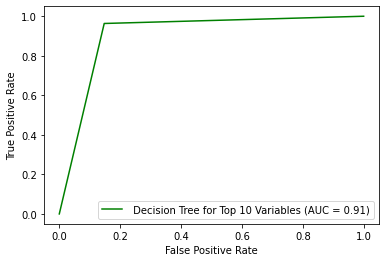

In [21]:

# create decision tree model and fit to training data for top 10 variables

dt_model_top10 = DecisionTreeClassifier(max_depth=5)
dt_model_top10.fit(X_train_top10_upsample, y_train_top10_upsample)
# predict probabilities with decision tree model
dt_probs_top10 = dt_model_top10.predict(X_test_top10_upsample)

fpr_dt, tpr_dt, _ = roc_curve(y_test_top10_upsample, dt_probs_top10)

roc_auc_dt = auc(fpr_dt, tpr_dt)


plt.plot(fpr_dt, tpr_dt, color='green', label=' Decision Tree for Top 10 Variables (AUC = %0.2f)' % roc_auc_dt)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [23]:

# predict probabilities with neural network model
nn_probs = model_upsample_all.predict(X_test_upsample)
# calculate fpr and tpr for different thresholds
fpr_nn, tpr_nn, thresholds = roc_curve(y_test_upsample, nn_probs)
# calculate overall tpr and fpr by averaging across different thresholds
overall_tpr = np.mean(tpr_nn)
overall_fpr = np.mean(fpr_nn)
tnr_nn = 1 - overall_fpr
fnr_nn = 1 - overall_tpr
# calculate AUC
roc_auc_nn = auc(fpr_nn, tpr_nn)
# print results

print("Results for all variables")
print("Overall True Positive Rate:", overall_tpr)
print("Overall False Positive Rate:", overall_fpr)
print("True Negative Rate:", tnr_nn)
print("False Negative Rate:", fnr_nn)
print("AUC:", roc_auc_nn)

print ("-------------------")

# predict probabilities with neural network model
nn_probs_top10 = model_upsample_top10.predict(X_test_top10_upsample)
# calculate fpr and tpr for different thresholds
fpr_nn, tpr_nn, thresholds = roc_curve(y_test_top10_upsample, nn_probs_top10)
# calculate overall tpr and fpr by averaging across different thresholds
overall_tpr = np.mean(tpr_nn)
overall_fpr = np.mean(fpr_nn)
tnr_nn = 1 - overall_fpr
fnr_nn = 1 - overall_tpr
# calculate AUC
roc_auc_nn = auc(fpr_nn, tpr_nn)
# print results
print("Results for top 10 variables")
print("Overall True Positive Rate:", overall_tpr)
print("Overall False Positive Rate:", overall_fpr)
print("True Negative Rate:", tnr_nn)
print("False Negative Rate:", fnr_nn)
print("AUC:", roc_auc_nn)

83/83 [==============================] - 0s 2ms/step
Results for all variables
Overall True Positive Rate: 0.5865091463414634
Overall False Positive Rate: 0.03356394327309237
True Negative Rate: 0.9664360567269077
False Negative Rate: 0.41349085365853655
AUC: 0.9869697922788717
-------------------
83/83 [==============================] - 0s 1ms/step
Results for top 10 variables
Overall True Positive Rate: 0.5617444326617179
Overall False Positive Rate: 0.10101711192596474
True Negative Rate: 0.8989828880740353
False Negative Rate: 0.4382555673382821
AUC: 0.9226113677270056


In [ ]:
# # set threshold
# threshold = 0.5

# # predict probabilities with neural network model
# nn_probs = model_upsample_all.predict(X_test_upsample)

# # convert probabilities to binary values
# nn_preds = np.where(nn_probs >= threshold, 1, 0)


# # create confusion matrix
# cm_nn = confusion_matrix(y_test_upsample, nn_preds)

# # calculate true positives (TP), false positives (FP), false negatives (FN), true negatives (TN)
# tp_nn = cm_nn[1, 1]
# fp_nn = cm_nn[0, 1]
# fn_nn = cm_nn[1, 0]
# tn_nn = cm_nn[0, 0]

# # print results
# print("True Positives:", tp_nn)
# print("False Positives:", fp_nn)
# print("False Negatives:", fn_nn)
# print("True Negatives:", tn_nn)



In [ ]:

# # predict labels with neural network model
# nn_labels = (nn_probs >= 0.5).astype(int)

# # create confusion matrix
# cm_nn = confusion_matrix(y_test_upsample, nn_labels)

# # create heatmap of confusion matrix
# sns.heatmap(cm_nn, annot=True, cmap="Reds", fmt="d", cbar=False, 
#             xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
